In [2]:
%matplotlib inline

import numpy as np
import os
import json
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
nproc = range(1, 17)

In [4]:
def speedup(t_serial, t):
    return t_serial/t

In [5]:
def read_profiling_files(profile_dir_path="."):
    profiling_data = pd.DataFrame()

    json_filenames = [file for file in os.listdir(profile_dir_path) if file.endswith("_profiling.json")]

    for json_filename in json_filenames:
        with open(os.path.join(profile_dir_path, json_filename)) as json_file:
            profiling_data = profiling_data.append(json.load(json_file), ignore_index=True)
            profiling_data = profiling_data.sort_values(by=["n_processes"], ignore_index=True)

    profiling_data.n_processes = profiling_data.n_processes.astype(int)
    profiling_data = profiling_data.sort_values(by=["n_processes"], ignore_index=True)

    return profiling_data

## Weak scaling

In [6]:
# DGX-2
#weak_scaling_profiling_data = read_profiling_files("output_dgx-2/weak_scaling/2022-06-09T134809/")

# HGX
weak_scaling_profiling_data = read_profiling_files("output_hgx/weak_scaling/2022-06-16T162931/")
##weak_scaling_profiling_data = read_profiling_files("output_hgx/weak_scaling/2022-06-16T170630/")

print(weak_scaling_profiling_data)

     t_init    t_total                                            outfile  \
0  1.248385  20.045867  /work/martinls/230527/ShallowWaterGPU/mpi_out_...   
1  1.687006  21.810200  /work/martinls/230528/ShallowWaterGPU/mpi_out_...   
2  2.178354  24.593490  /work/martinls/230530/ShallowWaterGPU/mpi_out_...   
3  2.690906  25.624513  /work/martinls/230531/ShallowWaterGPU/mpi_out_...   
4  3.629718  26.697773  /work/martinls/230532/ShallowWaterGPU/mpi_out_...   
5  4.364927  27.958164  /work/martinls/230533/ShallowWaterGPU/mpi_out_...   
6  5.628270  29.105025  /work/martinls/230534/ShallowWaterGPU/mpi_out_...   
7  6.777608  30.504384  /work/martinls/230535/ShallowWaterGPU/mpi_out_...   

   t_sim_init  t_nc_write  t_full_step  t_mpi_halo_exchange  \
0    1.880793   12.403532     4.007889                  0.0   
1    2.117109   12.576457     4.909249                  0.0   
2    2.050483   12.774502     7.045701                  0.0   
3    2.216515   13.096246     7.060501                

## Strong scaling

In [7]:
def amdahls_speedup(parallel_share, nproc):
    serial_share = 1.0 - parallel_share
    return [1.0 / (serial_share + parallel_share / float(n)) for n in nproc]

In [8]:
def gustafsons_speedup(parallel_share, nproc):
    serial_share = 1.0 - parallel_share
    return [serial_share + parallel_share * float(n) for n in nproc]

In [9]:
# DGX-2
#strong_scaling_profiling_data = read_profiling_files("output_dgx-2/strong_scaling/2022-06-09T160712/")

# HGX
strong_scaling_profiling_data = read_profiling_files("output_hgx/strong_scaling/2022-06-16T152945/")

print(strong_scaling_profiling_data)

     t_init     t_total                                            outfile  \
0  8.105802  127.329448  /work/martinls/230507/ShallowWaterGPU/mpi_out_...   
1  8.391940  106.173041  /work/martinls/230508/ShallowWaterGPU/mpi_out_...   
2  8.316061   89.259504  /work/martinls/230509/ShallowWaterGPU/mpi_out_...   
3  9.480870   82.180610  /work/martinls/230510/ShallowWaterGPU/mpi_out_...   
4  9.948056   74.482449  /work/martinls/230511/ShallowWaterGPU/mpi_out_...   

   t_sim_init  t_nc_write  t_full_step  t_mpi_halo_exchange  \
0    5.656313   88.769145    23.461966                  0.0   
1    5.297291   72.174575    19.195057                  0.0   
2    5.045456   58.199751    16.024106                  0.0   
3    5.172412   52.463597    13.905023                  0.0   
4    4.827947   46.293962    12.370357                  0.0   

   t_mpi_halo_exchange_download  t_mpi_halo_exchange_upload  \
0                     21.429688                    0.028931   
1                     15.6

## Plotting

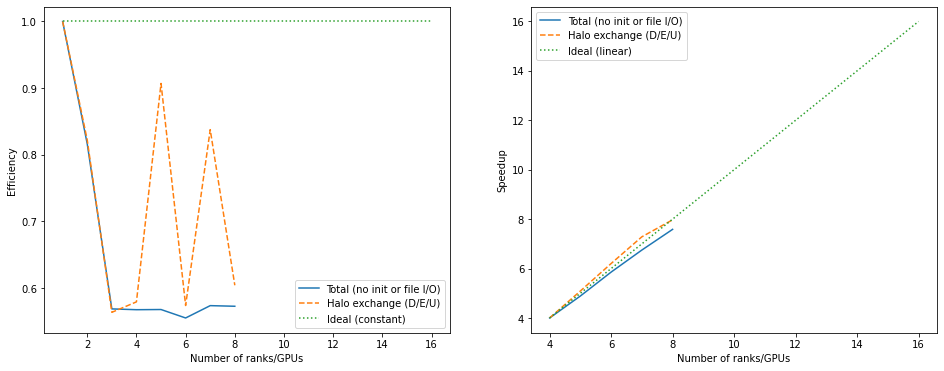

In [11]:
fig, (ax_weak, ax_strong) = plt.subplots(1, 2, figsize=(16,6))

t_total_no_init_or_file_io = weak_scaling_profiling_data["t_total"] \
                            -weak_scaling_profiling_data["t_init"] \
                            -weak_scaling_profiling_data["t_nc_write"] \
                            -weak_scaling_profiling_data["t_sim_init"]

t_total_halo_exchange = weak_scaling_profiling_data["t_mpi_halo_exchange_download"] \
                        +weak_scaling_profiling_data["t_mpi_halo_exchange_sendreceive"] \
                        +weak_scaling_profiling_data["t_mpi_halo_exchange_upload"]

#ax_weak.plot(weak_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
#    speedup(t_total_no_init_or_file_io[0], t_total_no_init_or_file_io), label="Total (no init or file I/O)")

ax_weak.plot(weak_scaling_profiling_data["n_processes"][0:].to_numpy(dtype="int"), 
    speedup(weak_scaling_profiling_data["t_full_step"][0], weak_scaling_profiling_data["t_full_step"][0:]), label="Total (no init or file I/O)")

ax_weak.plot(weak_scaling_profiling_data["n_processes"][0:].to_numpy(dtype="int"), 
    speedup(t_total_halo_exchange[0], t_total_halo_exchange[0:]), label="Halo exchange (D/E/U)", linestyle="dashed")

"""
ax_weak.plot(weak_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(weak_scaling_profiling_data["t_total"][0], weak_scaling_profiling_data["t_total"]), label="Total")

ax_weak.plot(weak_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(weak_scaling_profiling_data["t_mpi_halo_exchange_sendreceive"][0], weak_scaling_profiling_data["t_mpi_halo_exchange_sendreceive"]), label="MPI send/recv")

ax_weak.plot(weak_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(weak_scaling_profiling_data["t_mpi_halo_exchange_download"][0], weak_scaling_profiling_data["t_mpi_halo_exchange_download"]), label="Download (GPU->CPU)")

ax_weak.plot(weak_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(weak_scaling_profiling_data["t_mpi_halo_exchange_upload"][0], weak_scaling_profiling_data["t_mpi_halo_exchange_upload"]), label="Upload (CPU->GPU)")

ax_weak.plot(weak_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(weak_scaling_profiling_data["t_nc_write"][0], weak_scaling_profiling_data["t_nc_write"]), label="Write to file")

ax_weak.plot(weak_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(weak_scaling_profiling_data["t_init"][0], weak_scaling_profiling_data["t_init"]), label="Init")
"""

ax_weak.plot(nproc, np.ones(len(nproc)), label="Ideal (constant)", linestyle="dotted")

ax_weak.set_xlabel("Number of ranks/GPUs")
ax_weak.set_ylabel("Efficiency")
ax_weak.legend(loc="lower right")
#fig.show()

##############################################

#fig, ax = plt.subplots(figsize=(8,6))

t_total_no_init_or_file_io = strong_scaling_profiling_data["t_total"] \
                            -strong_scaling_profiling_data["t_init"] \
                            -strong_scaling_profiling_data["t_nc_write"] \
                            -strong_scaling_profiling_data["t_sim_init"]

t_total_halo_exchange = strong_scaling_profiling_data["t_mpi_halo_exchange_download"] \
                        +strong_scaling_profiling_data["t_mpi_halo_exchange_sendreceive"] \
                        +strong_scaling_profiling_data["t_mpi_halo_exchange_upload"]

#ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
#    speedup(t_total_no_init_or_file_io[0], t_total_no_init_or_file_io)*4, label="Total (no init or file I/O)")

ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(strong_scaling_profiling_data["t_full_step"][0], strong_scaling_profiling_data["t_full_step"])*4, label="Total (no init or file I/O)")

ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(t_total_halo_exchange[0], t_total_halo_exchange)*4, label="Halo exchange (D/E/U)", linestyle="dashed")

"""
ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(strong_scaling_profiling_data["t_total"][0], strong_scaling_profiling_data["t_total"])*4, label="Total")
    
ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(strong_scaling_profiling_data["t_mpi_halo_exchange_sendreceive"][0], strong_scaling_profiling_data["t_mpi_halo_exchange_sendreceive"]), label="MPI send/recv")

ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(strong_scaling_profiling_data["t_mpi_halo_exchange_download"][0], strong_scaling_profiling_data["t_mpi_halo_exchange_download"]), label="Download (GPU->CPU)")

ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(strong_scaling_profiling_data["t_mpi_halo_exchange_upload"][0], strong_scaling_profiling_data["t_mpi_halo_exchange_upload"]), label="Upload (CPU->GPU)")

ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(strong_scaling_profiling_data["t_nc_write"][0], strong_scaling_profiling_data["t_nc_write"]), label="Write to file")

ax_strong.plot(strong_scaling_profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(strong_scaling_profiling_data["t_init"][0], strong_scaling_profiling_data["t_init"]), label="Init")
"""

#ax_strong.plot(nproc, amdahls_speedup(0.9, nproc), label="Amdahls 90%", linestyle="dashed")
#ax_strong.plot(nproc, amdahls_speedup(0.5, nproc), label="Amdahls 50%", linestyle="dashed")
#ax_strong.plot(nproc, amdahls_speedup(0.1, nproc), label="Amdahls 10%", linestyle="dashed")

#ax_strong.plot(nproc, gustafsons_speedup(0.9, nproc), label="Gustafsons 90%")
#ax_strong.plot(nproc, gustafsons_speedup(0.5, nproc), label="Gustafsons 50%")
#ax_strong.plot(nproc, gustafsons_speedup(0.1, nproc), label="Gustafsons 10%")

ax_strong.plot(nproc[3:], nproc[3:], label="Ideal (linear)", linestyle="dotted")

ax_strong.set_xlabel("Number of ranks/GPUs")
ax_strong.set_ylabel("Speedup")
ax_strong.legend(loc="upper left")
fig.show()

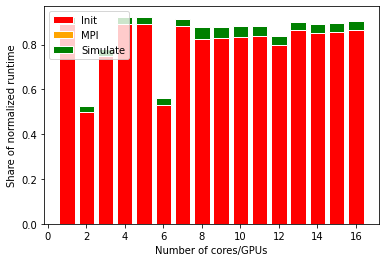

In [18]:
bar_width = 0.8

share_init = (profiling_data["t_init"]+profiling_data["t_sim_init"])/profiling_data["t_total"]
share_mpi = profiling_data["t_step_mpi_halo_exchange"]/profiling_data["t_total"]
share_simulate = profiling_data["t_step_mpi"]/profiling_data["t_total"]

plt.bar(profiling_data["n_processes"], 
    share_init, color='red', edgecolor='white', width=bar_width, label="Init")

plt.bar(profiling_data["n_processes"], 
    share_mpi, bottom=share_init, color='orange', edgecolor='white', width=bar_width, label="MPI")

plt.bar(profiling_data["n_processes"], 
    share_simulate, bottom=share_init+share_mpi , color='green', edgecolor='white', width=bar_width, label="Simulate")

plt.xlabel("Number of cores/GPUs")
plt.ylabel("Share of normalized runtime")
plt.legend(loc="upper left")

plt.show()

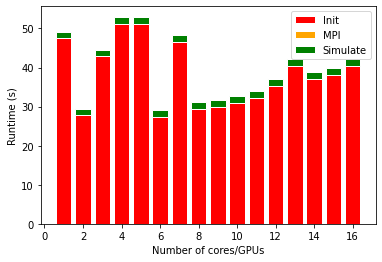

In [19]:
bar_width = 0.8

share_init = (profiling_data["t_init"]+profiling_data["t_sim_init"])
share_mpi = profiling_data["t_step_mpi_halo_exchange"]
share_simulate = profiling_data["t_step_mpi"]

plt.bar(profiling_data["n_processes"], 
    share_init, color='red', edgecolor='white', width=bar_width, label="Init")

plt.bar(profiling_data["n_processes"], 
    share_mpi, bottom=share_init, color='orange', edgecolor='white', width=bar_width, label="MPI")

plt.bar(profiling_data["n_processes"], 
    share_simulate, bottom=share_init+share_mpi , color='green', edgecolor='white', width=bar_width, label="Simulate")

plt.xlabel("Number of cores/GPUs")
plt.ylabel("Runtime (s)")
plt.legend(loc="upper right")

plt.show()

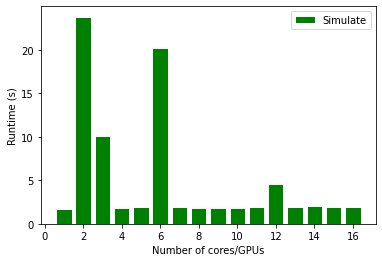

In [22]:
bar_width = 0.8

share_init = (profiling_data["t_init"]+profiling_data["t_sim_init"])
share_mpi = profiling_data["t_step_mpi_halo_exchange"]
share_simulate = profiling_data["t_step"]


plt.bar(profiling_data["n_processes"], 
    share_simulate, color='green', edgecolor='white', width=bar_width, label="Simulate")

plt.xlabel("Number of cores/GPUs")
plt.ylabel("Runtime (s)")
plt.legend(loc="upper right")

plt.show()

1. ~~Sjekk opp behandling av randvilkår. Fungerer ikke som det skal. Offset-problematikk. Få periodiske render til å funke med 1 (først hele domenet, så indre og yttre domene) og 2 subdomener.~~
2. Sjekk overføringer east-west. Kan vi droppe? – Ja, men se punkt 1.
3. ~~Sjekk IC-bug? Bare to felter i K-H?!~~
4. ~~Kjør lenger kjøring~~
5. Sjekk på OsloMet-boks!
6. Sjekk reproduserbarhet av løsning
7. Ny profilering og sjekk av parallelkjøring